In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Configuration:

# --- IO ---

# Where are the generated leaf dataset h5py files?
generated_leaf_dataset_path = f'/space/murph186/sorghum_segmentation/dataset/2022-03-10_leaf_c'
train_filename = f'sorghum_leaf__labeled_train.hdf5' 
val_filename = f'sorghum_leaf__labeled_validation.hdf5'
test_filename = f'sorghum_leaf__labeled_test.hdf5'

In [3]:
from os import path
import h5py as h5
import numpy as np

for filename in [train_filename, val_filename, test_filename]:

  print(f"Dataset statistics for {filename}:")

  example_leaf_data_filepath = path.join(generated_leaf_dataset_path, filename) 
  leaf_dataset = h5.File(example_leaf_data_filepath, 'r')

  print("Leaf dataset keys: " + ", ".join(leaf_dataset.keys()))
  for k in leaf_dataset.keys():
    print(f"  {k} : {len(leaf_dataset[k])}")

  print("Leaf dataset shape: ", leaf_dataset['points'].shape)
  print(f"Leaf count info: \n   values {np.unique(leaf_dataset['leaf_count'], return_counts=True)}")
  print("\n")

Dataset statistics for sorghum_leaf__labeled_train.hdf5:
Leaf dataset keys: _plant_index, leaf_count, leaf_index, points
  _plant_index : 4800
  leaf_count : 4800
  leaf_index : 4800
  points : 4800
Leaf dataset shape:  (4800, 80, 3)
Leaf count info: 
   values (array([1, 2]), array([2395, 2405]))


Dataset statistics for sorghum_leaf__labeled_validation.hdf5:
Leaf dataset keys: _plant_index, leaf_count, leaf_index, points
  _plant_index : 1600
  leaf_count : 1600
  leaf_index : 1600
  points : 1600
Leaf dataset shape:  (1600, 80, 3)
Leaf count info: 
   values (array([1, 2]), array([801, 799]))


Dataset statistics for sorghum_leaf__labeled_test.hdf5:
Leaf dataset keys: _plant_index, leaf_count, leaf_index, points
  _plant_index : 1600
  leaf_count : 1600
  leaf_index : 1600
  points : 1600
Leaf dataset shape:  (1600, 80, 3)
Leaf count info: 
   values (array([1, 2]), array([804, 796]))




In [4]:
# Visualize random sample of single, and paired leaves from training dataset:
example_leaf_data_filepath = path.join(generated_leaf_dataset_path, train_filename) 
leaf_dataset = h5.File(example_leaf_data_filepath, 'r')

sample_count = 6

leaf_counts = np.array(leaf_dataset["leaf_count"])
leaf_idx = np.array(leaf_dataset["leaf_index"])
leaf_points = np.array(leaf_dataset["points"])

single_sample_idx = np.where(leaf_counts == 1)
paired_sample_idx = np.where(leaf_counts == 2)

print(single_sample_idx)
print(paired_sample_idx)

selected_single_sample_idx = np.random.choice(single_sample_idx[0], size=sample_count)
selected_paired_sample_idx = np.random.choice(paired_sample_idx[0], size=sample_count)
print(f"Chosen single leaf sample indicies: {selected_single_sample_idx}")
print(f"Chosen paired leaf sample indicies: {selected_paired_sample_idx}")

(array([   1,    2,    3, ..., 4797, 4798, 4799]),)
(array([   0,    5,    8, ..., 4794, 4795, 4796]),)
Chosen single leaf sample indicies: [2130  731 1398 1948 3014 1826]
Chosen paired leaf sample indicies: [4652 2928 3677 3219 3854 4342]


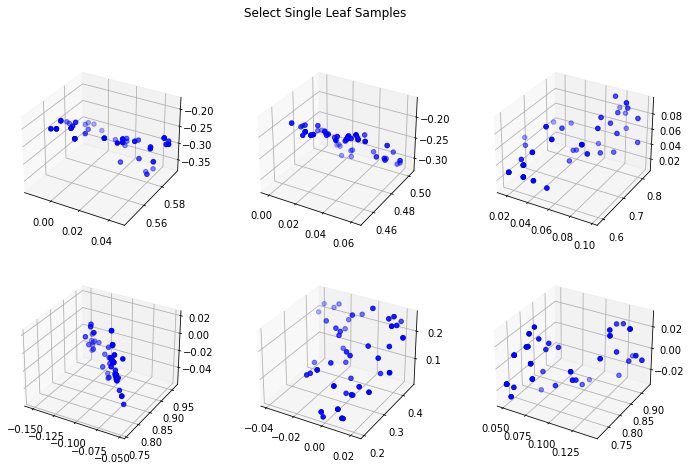

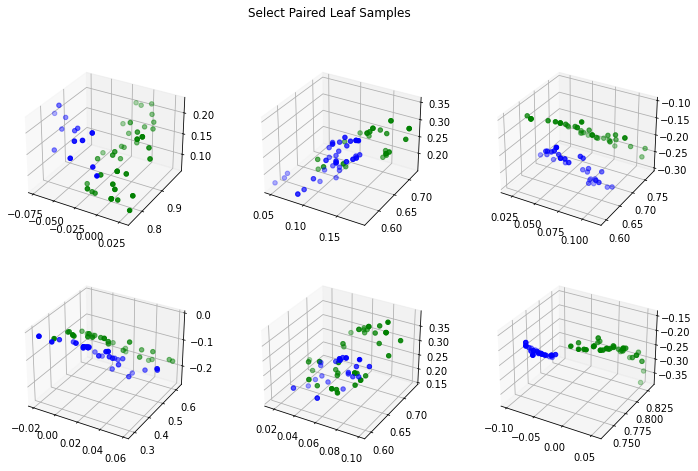

In [5]:
import matplotlib.pyplot as plt
import math

# How many columns to use in plots
columns = 3

selected_single_leaf_points = leaf_points[selected_single_sample_idx]
selected_paired_leaf_points = leaf_points[selected_paired_sample_idx]

selected_single_leaf_idx = leaf_idx[selected_single_sample_idx]
selected_paired_leaf_idx = leaf_idx[selected_paired_sample_idx]

def plot_selected_samples(selected_points, selected_idx, title):
  # Plot single leaf point clouds
  fig = plt.figure(figsize=(12, 0.6 * math.ceil(6 * sample_count/columns)))
  fig.suptitle(title)
  for i in range(sample_count):
    ax = fig.add_subplot(int(sample_count/columns), columns, i+1, projection='3d')

    unique_leaf_indices = np.unique(selected_idx[i])
    leaf_one_idx = np.where(selected_idx[i] == unique_leaf_indices[0])

    leaf_one_points = selected_points[i,leaf_one_idx,:]

    # plot points from leaf one
    ax.scatter(
      leaf_one_points[0,:,0], 
      leaf_one_points[0,:,1], 
      leaf_one_points[0,:,2], c="b")

    # if leaf #2 plot points from leaf #2
    if len(unique_leaf_indices) == 2:
      leaf_two_idx = np.where(selected_idx[i] == unique_leaf_indices[1])
      leaf_two_points = selected_points[i, leaf_two_idx, :]

      ax.scatter(
        leaf_two_points[0,:,0], 
        leaf_two_points[0,:,1], 
        leaf_two_points[0,:,2], c="g")
    
    if len(unique_leaf_indices) > 2:
      print("[WARN] Found sample with more than two leaves.")

  plt.show()

plot_selected_samples(selected_single_leaf_points, selected_single_leaf_idx, "Select Single Leaf Samples")
plot_selected_samples(selected_paired_leaf_points, selected_paired_leaf_idx, "Select Paired Leaf Samples")


Min centroid distance: 0.027950406247545218
Max centroid distance: 0.13611398619653803
Mean centroid distance: 0.07378194201293543


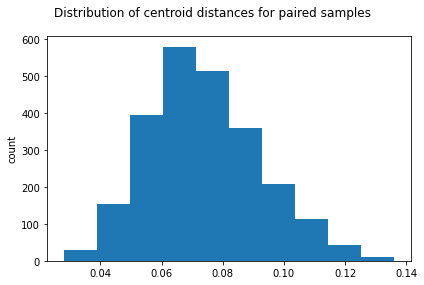

In [6]:
# Display paired sample with minimum pair distance
# Display paired sample with maximum pair distance
# Display histogram of pair distances

bin_count = 10

paired_points = leaf_points[paired_sample_idx]
paired_idx = leaf_idx[paired_sample_idx]

centroid_dists = []

for i in range(paired_points.shape[0]):
  selected_idx = paired_idx[i] 
  unique_leaf_indices = np.unique(selected_idx)

  leaf_one_idx = np.where(selected_idx == unique_leaf_indices[0])
  leaf_one_points = paired_points[i,leaf_one_idx,:]

  leaf_two_idx = np.where(selected_idx == unique_leaf_indices[1])
  leaf_two_points = paired_points[i, leaf_two_idx, :]

  leaf_one_centroid = np.mean(leaf_one_points, axis=1) 
  leaf_two_centroid = np.mean(leaf_two_points, axis=1)

  centroid_dists.append(np.linalg.norm(leaf_one_centroid - leaf_two_centroid))

centroid_dists = np.array(centroid_dists)
print(f"Min centroid distance: {np.min(centroid_dists)}")
print(f"Max centroid distance: {np.max(centroid_dists)}")
print(f"Mean centroid distance: {np.mean(centroid_dists)}")
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(centroid_dists, bins=bin_count)
fig.suptitle("Distribution of centroid distances for paired samples")
axs.set_ylabel("count")

plt.show()


In [7]:
import k3d

def plot_pair(i):

  selected_idx = paired_idx[i]
  unique_leaf_indices = np.unique(selected_idx)

  leaf_one_idx = np.where(selected_idx == unique_leaf_indices[0])
  leaf_one_points = paired_points[i,leaf_one_idx,:].astype(np.float32)

  leaf_two_idx = np.where(selected_idx == unique_leaf_indices[1])
  leaf_two_points = paired_points[i, leaf_two_idx, :].astype(np.float32)

  max_dist_points = paired_points[i]
  plot = k3d.plot(name='points')
  plt_points = k3d.points(positions=leaf_one_points, point_size=0.01, color=0x0000ff)
  plot += plt_points

  plt_points = k3d.points(positions=leaf_two_points, point_size=0.01, color=0x00ff00)
  plot += plt_points

  plt_points.shader='3d'
  plot.display()


max_idx = np.argmax(centroid_dists)
print("Maximum distance sample:")
plot_pair(max_idx)

min_idx = np.argmin(centroid_dists)
print("Minimum distance sample:")
plot_pair(min_idx)



Maximum distance sample:


Output()

Minimum distance sample:


Output()